In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [136]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)
        all_labels.extend(y.tolist())
        all_preds.extend(predicted.tolist())
        
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(dataloader)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, cm

In [137]:
def show_losses(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):
    clear_output()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label='Train Loss')
    plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label='Validation Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(len(train_acc_hist)), train_acc_hist, label='Train Accuracy')
    plt.plot(np.arange(len(val_acc_hist)), val_acc_hist, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

Предобработка данных

In [138]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Загрузка датасета

In [139]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

С чем мы имеем дело?

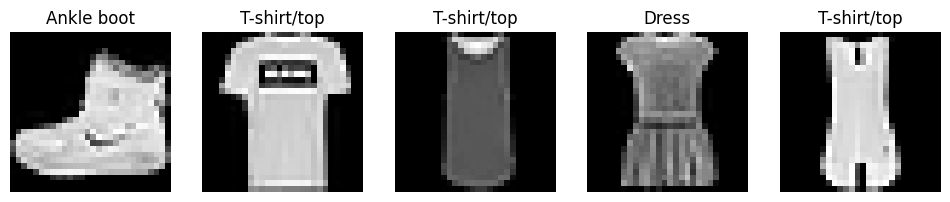

In [140]:
def show_images(dataset, num_images=5):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i].set_title(classes[label])
        axes[i].axis('off')

    plt.show()

show_images(trainset, num_images=5)

Ну тип одежда

Выделение данных для валидации

In [141]:
val_size = int(0.1 * len(trainset))
test_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size - test_size
trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])

In [142]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Сама модель, дропаут здорово спас от переобучения

In [143]:
model = nn.Sequential(
    nn.Flatten(),        
    nn.Linear(28 * 28, 128),  
    nn.ReLU(),          
    nn.Dropout(0.5),              
    nn.Linear(128, 64),  
    nn.ReLU(),           
    nn.Dropout(0.5),              
    nn.Linear(64, 10)    
)

Функция лосса и оптимизатор

In [144]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [145]:
epochs = 20
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

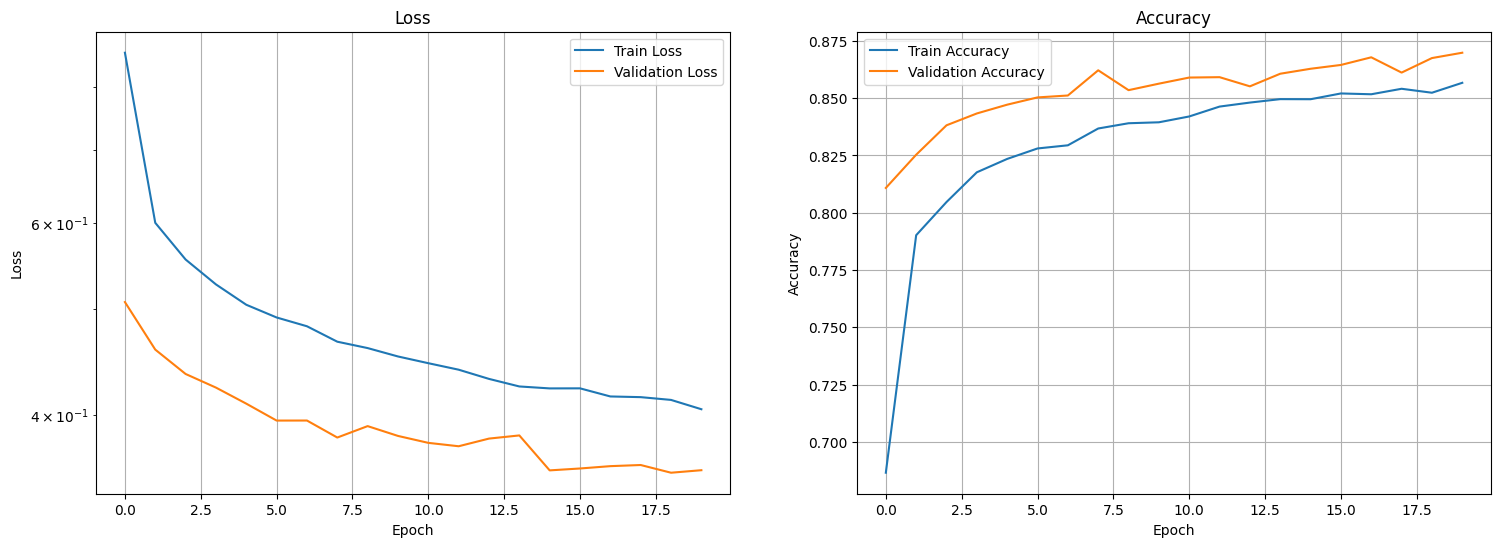

Epoch 20/20, Train Loss: 0.4046, Val Loss: 0.3556


In [146]:
for epoch in range(epochs):
    train_loss = run(model, trainloader, loss_func, optimizer)
    val_loss = run(model, valloader, loss_func)
    
    train_losses.append(train_loss[0])
    val_losses.append(val_loss[0])
    train_accuracy.append(train_loss[1])
    val_accuracy.append(val_loss[1])

    show_losses(train_losses, val_losses, train_accuracy, val_accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[0]:.4f}, Val Loss: {val_loss[0]:.4f}')

In [147]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [148]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = run(model, testloader, loss_func)
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = run(model, valloader, loss_func)

In [149]:
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print('Validation Confusion Matrix:')
print(val_cm)

Validation Accuracy: 0.8698
Validation Precision: 0.8719
Validation Recall: 0.8698
Validation F1 Score: 0.8677
Validation Confusion Matrix:
[[508   1   7  23   3   0  43   0   4   0]
 [  0 554   1  21   1   0   1   0   0   0]
 [  4   0 465   7  90   0  28   0   2   0]
 [ 15   4   7 542  32   0  10   0   2   0]
 [  0   0  37  14 529   0  19   0   4   0]
 [  0   0   0   1   0 545   0  39   2  15]
 [114   1  57   8  88   0 343   0  12   0]
 [  0   0   0   0   0   2   0 576   1  24]
 [  0   0   2   0   6   3   5   3 587   0]
 [  0   0   1   0   0   5   0  12   0 570]]


In [150]:
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Test Confusion Matrix:')
print(test_cm)

Test Accuracy: 0.8782
Test Precision: 0.8797
Test Recall: 0.8782
Test F1 Score: 0.8765
Test Confusion Matrix:
[[533   1   8  25   6   0  41   0   7   0]
 [  2 601   0  15   0   0   2   0   1   0]
 [  6   0 476   2  88   0  29   0   2   0]
 [ 16   5   3 538  24   0  11   0   1   0]
 [  0   1  27  21 530   0  17   0   2   0]
 [  0   0   0   1   0 550   0  37   2  13]
 [ 96   0  48  15  79   0 335   0   9   0]
 [  0   0   0   0   0   6   0 544   0  18]
 [  2   0   3   5   6   3   6   2 601   0]
 [  0   0   0   0   0   1   1  15   0 561]]


'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

Метрики модели (см. данные выше) не отличные, но вполне удовлетворительные. Лучшей показала себя модель с 4мя слоями, в качестве функции активации - ReLu, хороший вариант для задачи классификации данных изображений, оптимизатор и функция лосса, CrossEntropyLoss и SGD соответственно, была выбрана на основе опыта предыдущей задачи и др. источников типа kaggle, reddit, ХАБР. Количество эпох (гиперпараметр) - вроде нормальное. Большинство ошибок - между "смежными" типами одежды.